# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 5 steps, each in a single notebook:
1. Get probe template
2. **Get the Bragg disks**
3. Calculate lattice vectors
4. Calculate strain
5. Visualize strain maps

# Notebook 2: Get the Bragg disks

In this step the Bragg disks are located, as follows:

* For each diffraction pattern:
    * Cross correlate (or hybrid cross-phase correlate) the DP with the probe kernel
    * Get a first guess at Bragg disk positions by identifying positions and intensities of all local maxima
    * Filter out erroneous peaks by removing those too close together, in order of decreasing intensity
* Save Bragg disks list

### Import packages, load data

In [2]:
import py4DSTEM

from py4DSTEM.process.datastructure import DataCube, DiffractionSlice, RealSlice, PointList

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.morphology import binary_dilation as binary_dilation
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

from time import time

/Users/Ben/Code/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Load the raw data
fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(60,60)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

Reading file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3...

/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3 is not a py4DSTEM file.  Reading with hyperspy...


In [12]:
# Load the template
fp_probetemplate = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_probetemplate)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    probe_kernel                        DiffractionSlice    


In [13]:
probe_kernel = browser.get_dataobject(0)

### Loop through DPs, finding all Bragg disks

In [14]:
corrPower = 0.9
sigma_gaussianFilter = 2
edge_boundary = 20
maxNumPeaks = 45
minPeakSpacing = 32

coords = [('rx',float),('ry',float),('qx',float),('qy',float),('intensity',float)]
Bragg_peak_point_list = PointList(coordinates=coords, parentDataCube=dc, name="Bragg_disks")

t0=time()
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel.data2D))
for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        print("Analyzing scan position {},{}".format(Ri,Rj))

        # Get diffraction pattern
        DP = dc.data4D[Ri,Rj,:,:]
        
        # Cross correlation     
        cc = py4DSTEM.process.utils.get_cross_correlation_fk(DP,probe_kernel_FT,corrPower)

        # Gaussian smoothing
        cc = np.maximum(cc,0)
        cc = gaussian_filter(cc, sigma_gaussianFilter)
        
        # Get maximal points
        max_points = py4DSTEM.process.utils.get_maximal_points(cc)
        
        # Remove points at edges
        max_points[:edge_boundary,:]=False
        max_points[-edge_boundary:,:]=False
        max_points[:,:edge_boundary]=False
        max_points[:,-edge_boundary:]=False    
       
        # Make point_list with structured array datatype ('rx','ry','qx','qy','intensity')
        point_list = PointList(coordinates=coords, parentDataCube=dc, save_behavior=False)

        max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
        point_intensities = cc[max_point_indices_x,max_point_indices_y]

        length = len(point_intensities)
        for i in range(length):
            new_point = (Ri,Rj,max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
            point_list.add_point(new_point)
        
        # Order point list, keep only up to maxNumPeaks
        numPeaks = min(maxNumPeaks,length)
        point_list.sort(coordinate='intensity',order='descending')
        point_list.data = point_list.data[:numPeaks]        
        
        # Remove peaks that are too close together
        r2 = minPeakSpacing**2
        deletePeaks = np.zeros(numPeaks,dtype=bool)
        for i in range(numPeaks):
            if deletePeaks[i] == False:
                tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                          (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
                tooClose[:i+1] = False
                deletePeaks[tooClose] = True
        point_list.remove_points(deletePeaks)
    
        # Add current point list to running list
        Bragg_peak_point_list.add_pointlist(point_list)
            
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Analyzing scan position 0,0
Analyzing scan position 0,1
Analyzing scan position 0,2
Analyzing scan position 0,3
Analyzing scan position 0,4
Analyzing scan position 0,5
Analyzing scan position 0,6
Analyzing scan position 0,7
Analyzing scan position 0,8
Analyzing scan position 0,9
Analyzing scan position 0,10
Analyzing scan position 0,11
Analyzing scan position 0,12
Analyzing scan position 0,13
Analyzing scan position 0,14
Analyzing scan position 0,15
Analyzing scan position 0,16
Analyzing scan position 0,17
Analyzing scan position 0,18
Analyzing scan position 0,19
Analyzing scan position 0,20
Analyzing scan position 0,21
Analyzing scan position 0,22
Analyzing scan position 0,23
Analyzing scan position 0,24
Analyzing scan position 0,25
Analyzing scan position 0,26
Analyzing scan position 0,27
Analyzing scan position 0,28
Analyzing scan position 0,29
Analyzing scan position 0,30
Analyzing scan position 0,31
Analyzing scan position 0,32
Analyzing scan position 0,33
Analyzing scan position 

Analyzing scan position 4,47
Analyzing scan position 4,48
Analyzing scan position 4,49
Analyzing scan position 4,50
Analyzing scan position 4,51
Analyzing scan position 4,52
Analyzing scan position 4,53
Analyzing scan position 4,54
Analyzing scan position 4,55
Analyzing scan position 4,56
Analyzing scan position 4,57
Analyzing scan position 4,58
Analyzing scan position 4,59
Analyzing scan position 5,0
Analyzing scan position 5,1
Analyzing scan position 5,2
Analyzing scan position 5,3
Analyzing scan position 5,4
Analyzing scan position 5,5
Analyzing scan position 5,6
Analyzing scan position 5,7
Analyzing scan position 5,8
Analyzing scan position 5,9
Analyzing scan position 5,10
Analyzing scan position 5,11
Analyzing scan position 5,12
Analyzing scan position 5,13
Analyzing scan position 5,14
Analyzing scan position 5,15
Analyzing scan position 5,16
Analyzing scan position 5,17
Analyzing scan position 5,18
Analyzing scan position 5,19
Analyzing scan position 5,20
Analyzing scan position 

Analyzing scan position 9,32
Analyzing scan position 9,33
Analyzing scan position 9,34
Analyzing scan position 9,35
Analyzing scan position 9,36
Analyzing scan position 9,37
Analyzing scan position 9,38
Analyzing scan position 9,39
Analyzing scan position 9,40
Analyzing scan position 9,41
Analyzing scan position 9,42
Analyzing scan position 9,43
Analyzing scan position 9,44
Analyzing scan position 9,45
Analyzing scan position 9,46
Analyzing scan position 9,47
Analyzing scan position 9,48
Analyzing scan position 9,49
Analyzing scan position 9,50
Analyzing scan position 9,51
Analyzing scan position 9,52
Analyzing scan position 9,53
Analyzing scan position 9,54
Analyzing scan position 9,55
Analyzing scan position 9,56
Analyzing scan position 9,57
Analyzing scan position 9,58
Analyzing scan position 9,59
Analyzing scan position 10,0
Analyzing scan position 10,1
Analyzing scan position 10,2
Analyzing scan position 10,3
Analyzing scan position 10,4
Analyzing scan position 10,5
Analyzing scan

Analyzing scan position 14,9
Analyzing scan position 14,10
Analyzing scan position 14,11
Analyzing scan position 14,12
Analyzing scan position 14,13
Analyzing scan position 14,14
Analyzing scan position 14,15
Analyzing scan position 14,16
Analyzing scan position 14,17
Analyzing scan position 14,18
Analyzing scan position 14,19
Analyzing scan position 14,20
Analyzing scan position 14,21
Analyzing scan position 14,22
Analyzing scan position 14,23
Analyzing scan position 14,24
Analyzing scan position 14,25
Analyzing scan position 14,26
Analyzing scan position 14,27
Analyzing scan position 14,28
Analyzing scan position 14,29
Analyzing scan position 14,30
Analyzing scan position 14,31
Analyzing scan position 14,32
Analyzing scan position 14,33
Analyzing scan position 14,34
Analyzing scan position 14,35
Analyzing scan position 14,36
Analyzing scan position 14,37
Analyzing scan position 14,38
Analyzing scan position 14,39
Analyzing scan position 14,40
Analyzing scan position 14,41
Analyzing s

Analyzing scan position 18,47
Analyzing scan position 18,48
Analyzing scan position 18,49
Analyzing scan position 18,50
Analyzing scan position 18,51
Analyzing scan position 18,52
Analyzing scan position 18,53
Analyzing scan position 18,54
Analyzing scan position 18,55
Analyzing scan position 18,56
Analyzing scan position 18,57
Analyzing scan position 18,58
Analyzing scan position 18,59
Analyzing scan position 19,0
Analyzing scan position 19,1
Analyzing scan position 19,2
Analyzing scan position 19,3
Analyzing scan position 19,4
Analyzing scan position 19,5
Analyzing scan position 19,6
Analyzing scan position 19,7
Analyzing scan position 19,8
Analyzing scan position 19,9
Analyzing scan position 19,10
Analyzing scan position 19,11
Analyzing scan position 19,12
Analyzing scan position 19,13
Analyzing scan position 19,14
Analyzing scan position 19,15
Analyzing scan position 19,16
Analyzing scan position 19,17
Analyzing scan position 19,18
Analyzing scan position 19,19
Analyzing scan posit

Analyzing scan position 23,23
Analyzing scan position 23,24
Analyzing scan position 23,25
Analyzing scan position 23,26
Analyzing scan position 23,27
Analyzing scan position 23,28
Analyzing scan position 23,29
Analyzing scan position 23,30
Analyzing scan position 23,31
Analyzing scan position 23,32
Analyzing scan position 23,33
Analyzing scan position 23,34
Analyzing scan position 23,35
Analyzing scan position 23,36
Analyzing scan position 23,37
Analyzing scan position 23,38
Analyzing scan position 23,39
Analyzing scan position 23,40
Analyzing scan position 23,41
Analyzing scan position 23,42
Analyzing scan position 23,43
Analyzing scan position 23,44
Analyzing scan position 23,45
Analyzing scan position 23,46
Analyzing scan position 23,47
Analyzing scan position 23,48
Analyzing scan position 23,49
Analyzing scan position 23,50
Analyzing scan position 23,51
Analyzing scan position 23,52
Analyzing scan position 23,53
Analyzing scan position 23,54
Analyzing scan position 23,55
Analyzing 

Analyzing scan position 27,58
Analyzing scan position 27,59
Analyzing scan position 28,0
Analyzing scan position 28,1
Analyzing scan position 28,2
Analyzing scan position 28,3
Analyzing scan position 28,4
Analyzing scan position 28,5
Analyzing scan position 28,6
Analyzing scan position 28,7
Analyzing scan position 28,8
Analyzing scan position 28,9
Analyzing scan position 28,10
Analyzing scan position 28,11
Analyzing scan position 28,12
Analyzing scan position 28,13
Analyzing scan position 28,14
Analyzing scan position 28,15
Analyzing scan position 28,16
Analyzing scan position 28,17
Analyzing scan position 28,18
Analyzing scan position 28,19
Analyzing scan position 28,20
Analyzing scan position 28,21
Analyzing scan position 28,22
Analyzing scan position 28,23
Analyzing scan position 28,24
Analyzing scan position 28,25
Analyzing scan position 28,26
Analyzing scan position 28,27
Analyzing scan position 28,28
Analyzing scan position 28,29
Analyzing scan position 28,30
Analyzing scan posit

Analyzing scan position 32,34
Analyzing scan position 32,35
Analyzing scan position 32,36
Analyzing scan position 32,37
Analyzing scan position 32,38
Analyzing scan position 32,39
Analyzing scan position 32,40
Analyzing scan position 32,41
Analyzing scan position 32,42
Analyzing scan position 32,43
Analyzing scan position 32,44
Analyzing scan position 32,45
Analyzing scan position 32,46
Analyzing scan position 32,47
Analyzing scan position 32,48
Analyzing scan position 32,49
Analyzing scan position 32,50
Analyzing scan position 32,51
Analyzing scan position 32,52
Analyzing scan position 32,53
Analyzing scan position 32,54
Analyzing scan position 32,55
Analyzing scan position 32,56
Analyzing scan position 32,57
Analyzing scan position 32,58
Analyzing scan position 32,59
Analyzing scan position 33,0
Analyzing scan position 33,1
Analyzing scan position 33,2
Analyzing scan position 33,3
Analyzing scan position 33,4
Analyzing scan position 33,5
Analyzing scan position 33,6
Analyzing scan po

Analyzing scan position 37,10
Analyzing scan position 37,11
Analyzing scan position 37,12
Analyzing scan position 37,13
Analyzing scan position 37,14
Analyzing scan position 37,15
Analyzing scan position 37,16
Analyzing scan position 37,17
Analyzing scan position 37,18
Analyzing scan position 37,19
Analyzing scan position 37,20
Analyzing scan position 37,21
Analyzing scan position 37,22
Analyzing scan position 37,23
Analyzing scan position 37,24
Analyzing scan position 37,25
Analyzing scan position 37,26
Analyzing scan position 37,27
Analyzing scan position 37,28
Analyzing scan position 37,29
Analyzing scan position 37,30
Analyzing scan position 37,31
Analyzing scan position 37,32
Analyzing scan position 37,33
Analyzing scan position 37,34
Analyzing scan position 37,35
Analyzing scan position 37,36
Analyzing scan position 37,37
Analyzing scan position 37,38
Analyzing scan position 37,39
Analyzing scan position 37,40
Analyzing scan position 37,41
Analyzing scan position 37,42
Analyzing 

Analyzing scan position 41,45
Analyzing scan position 41,46
Analyzing scan position 41,47
Analyzing scan position 41,48
Analyzing scan position 41,49
Analyzing scan position 41,50
Analyzing scan position 41,51
Analyzing scan position 41,52
Analyzing scan position 41,53
Analyzing scan position 41,54
Analyzing scan position 41,55
Analyzing scan position 41,56
Analyzing scan position 41,57
Analyzing scan position 41,58
Analyzing scan position 41,59
Analyzing scan position 42,0
Analyzing scan position 42,1
Analyzing scan position 42,2
Analyzing scan position 42,3
Analyzing scan position 42,4
Analyzing scan position 42,5
Analyzing scan position 42,6
Analyzing scan position 42,7
Analyzing scan position 42,8
Analyzing scan position 42,9
Analyzing scan position 42,10
Analyzing scan position 42,11
Analyzing scan position 42,12
Analyzing scan position 42,13
Analyzing scan position 42,14
Analyzing scan position 42,15
Analyzing scan position 42,16
Analyzing scan position 42,17
Analyzing scan posit

Analyzing scan position 46,21
Analyzing scan position 46,22
Analyzing scan position 46,23
Analyzing scan position 46,24
Analyzing scan position 46,25
Analyzing scan position 46,26
Analyzing scan position 46,27
Analyzing scan position 46,28
Analyzing scan position 46,29
Analyzing scan position 46,30
Analyzing scan position 46,31
Analyzing scan position 46,32
Analyzing scan position 46,33
Analyzing scan position 46,34
Analyzing scan position 46,35
Analyzing scan position 46,36
Analyzing scan position 46,37
Analyzing scan position 46,38
Analyzing scan position 46,39
Analyzing scan position 46,40
Analyzing scan position 46,41
Analyzing scan position 46,42
Analyzing scan position 46,43
Analyzing scan position 46,44
Analyzing scan position 46,45
Analyzing scan position 46,46
Analyzing scan position 46,47
Analyzing scan position 46,48
Analyzing scan position 46,49
Analyzing scan position 46,50
Analyzing scan position 46,51
Analyzing scan position 46,52
Analyzing scan position 46,53
Analyzing 

Analyzing scan position 50,57
Analyzing scan position 50,58
Analyzing scan position 50,59
Analyzing scan position 51,0
Analyzing scan position 51,1
Analyzing scan position 51,2
Analyzing scan position 51,3
Analyzing scan position 51,4
Analyzing scan position 51,5
Analyzing scan position 51,6
Analyzing scan position 51,7
Analyzing scan position 51,8
Analyzing scan position 51,9
Analyzing scan position 51,10
Analyzing scan position 51,11
Analyzing scan position 51,12
Analyzing scan position 51,13
Analyzing scan position 51,14
Analyzing scan position 51,15
Analyzing scan position 51,16
Analyzing scan position 51,17
Analyzing scan position 51,18
Analyzing scan position 51,19
Analyzing scan position 51,20
Analyzing scan position 51,21
Analyzing scan position 51,22
Analyzing scan position 51,23
Analyzing scan position 51,24
Analyzing scan position 51,25
Analyzing scan position 51,26
Analyzing scan position 51,27
Analyzing scan position 51,28
Analyzing scan position 51,29
Analyzing scan posit

Analyzing scan position 55,33
Analyzing scan position 55,34
Analyzing scan position 55,35
Analyzing scan position 55,36
Analyzing scan position 55,37
Analyzing scan position 55,38
Analyzing scan position 55,39
Analyzing scan position 55,40
Analyzing scan position 55,41
Analyzing scan position 55,42
Analyzing scan position 55,43
Analyzing scan position 55,44
Analyzing scan position 55,45
Analyzing scan position 55,46
Analyzing scan position 55,47
Analyzing scan position 55,48
Analyzing scan position 55,49
Analyzing scan position 55,50
Analyzing scan position 55,51
Analyzing scan position 55,52
Analyzing scan position 55,53
Analyzing scan position 55,54
Analyzing scan position 55,55
Analyzing scan position 55,56
Analyzing scan position 55,57
Analyzing scan position 55,58
Analyzing scan position 55,59
Analyzing scan position 56,0
Analyzing scan position 56,1
Analyzing scan position 56,2
Analyzing scan position 56,3
Analyzing scan position 56,4
Analyzing scan position 56,5
Analyzing scan p

### Save Bragg disk list

In [15]:
# Save

savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5"
py4DSTEM.readwrite.save_dataobject(Bragg_peak_point_list,savepath)

Creating file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5...
Writing metadata...
Done.


In [ ]:
# Get the average deconvolution

average_deconvolution = np.zeros((dc.Q_Ny,dc.Q_Nx))

for i in range(len(Bragg_peak_point_list.data)):
    qx = int(Bragg_peak_point_list.data['qx'][i])
    qy = int(Bragg_peak_point_list.data['qy'][i])
    average_deconvolution[qx,qy] += Bragg_peak_point_list.data['intensity'][i]

In [ ]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution)
x0,y0=int(x0),int(y0)
rad=40

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution)
ax12.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution**0.25,cmap='jet')
ax22.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

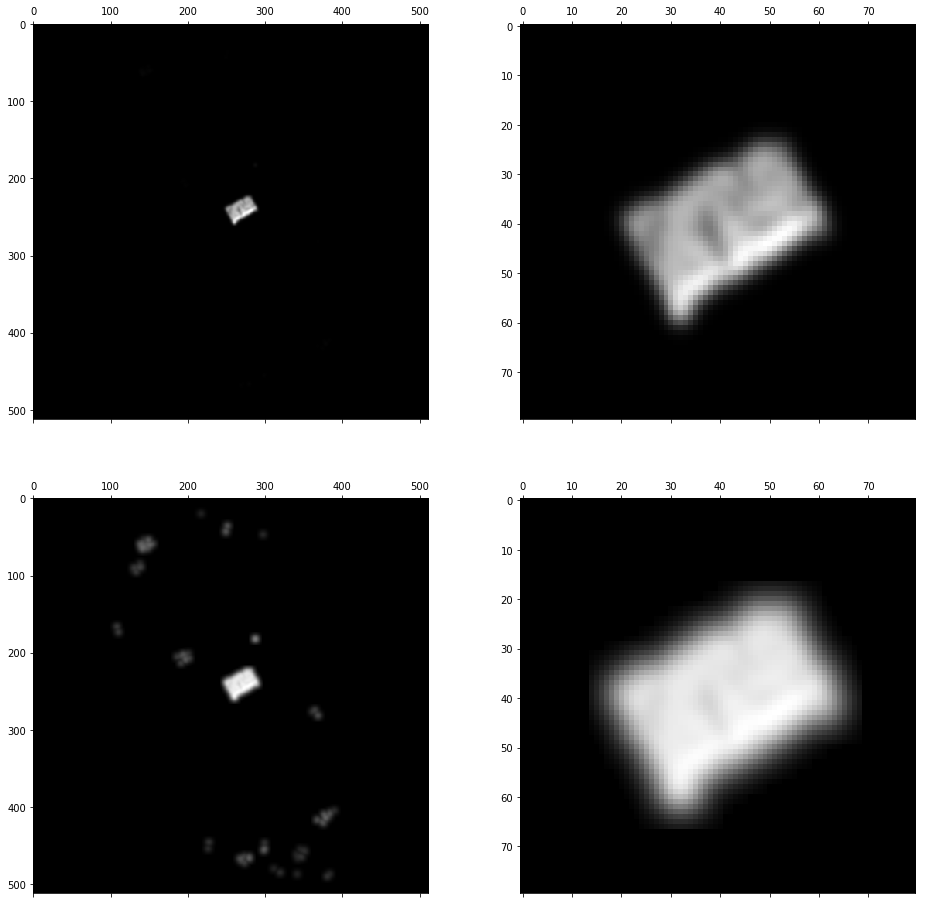

In [37]:
# Smooth average deconvolution

sigma_gaussianFilter2 = 2
average_deconvolution_gf = gaussian_filter(average_deconvolution, sigma_gaussianFilter2)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution_gf)
ax12.matshow(average_deconvolution_gf[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution_gf**0.25)
ax22.matshow(average_deconvolution_gf[x0-rad:x0+rad,y0-rad:y0+rad]**0.25)
plt.show()

In [38]:
# Get average central beam position, from CoM of average deconvolution

central_beam_qx0, central_beam_qy0 = py4DSTEM.process.utils.get_CoM(average_deconvolution)

In [39]:
# Get the average deconvolution

average_deconvolution = np.zeros((dc.Q_Ny,dc.Q_Nx))

for i in range(len(Bragg_peak_point_list.data)):
    qx = int(Bragg_peak_point_list.data['qx'][i])
    qy = int(Bragg_peak_point_list.data['qy'][i])
    average_deconvolution[qx,qy] += Bragg_peak_point_list.data['intensity'][i]

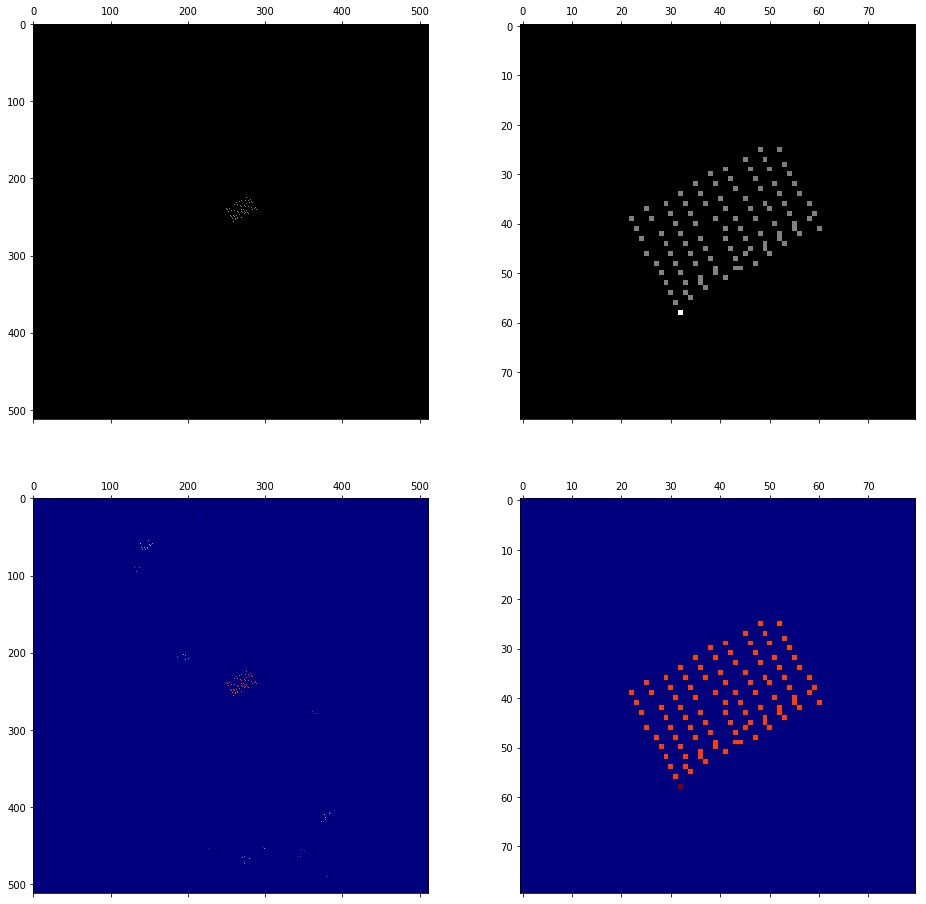

In [40]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution)
x0,y0=int(x0),int(y0)
rad=40

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution)
ax12.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution**0.25,cmap='jet')
ax22.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

In [41]:
# Get the diffraction shifts for each DP, using closest peak to CoM of average deconvolution

diffraction_shifts_intensity = RealSlice(data=np.empty((2,dc.R_Nx,dc.R_Ny)),
                                         parentDataCube=dc,slicelabels=('x','y'))
diffraction_shifts_position = RealSlice(data=np.empty((2,dc.R_Nx,dc.R_Ny))
                                        ,parentDataCube=dc,slicelabels=('x','y'))

for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        Rij_point_list = Bragg_peak_point_list.get_subpointlist([('rx',Ri),('ry',Rj)])
        
        index = np.argmax(Rij_point_list.data['intensity'])
        diffraction_shifts_intensity.data2D['x'][Ri,Rj] = Rij_point_list.data['qx'][index]
        diffraction_shifts_intensity.data2D['y'][Ri,Rj] = Rij_point_list.data['qy'][index]
        
        r2 = (Rij_point_list.data['qx']-central_beam_qx0)**2 + (Rij_point_list.data['qy']-central_beam_qy0)**2
        index = np.argmin(r2)
        diffraction_shifts_position.data2D['x'][Ri,Rj] = Rij_point_list.data['qx'][index]
        diffraction_shifts_position.data2D['y'][Ri,Rj] = Rij_point_list.data['qy'][index]

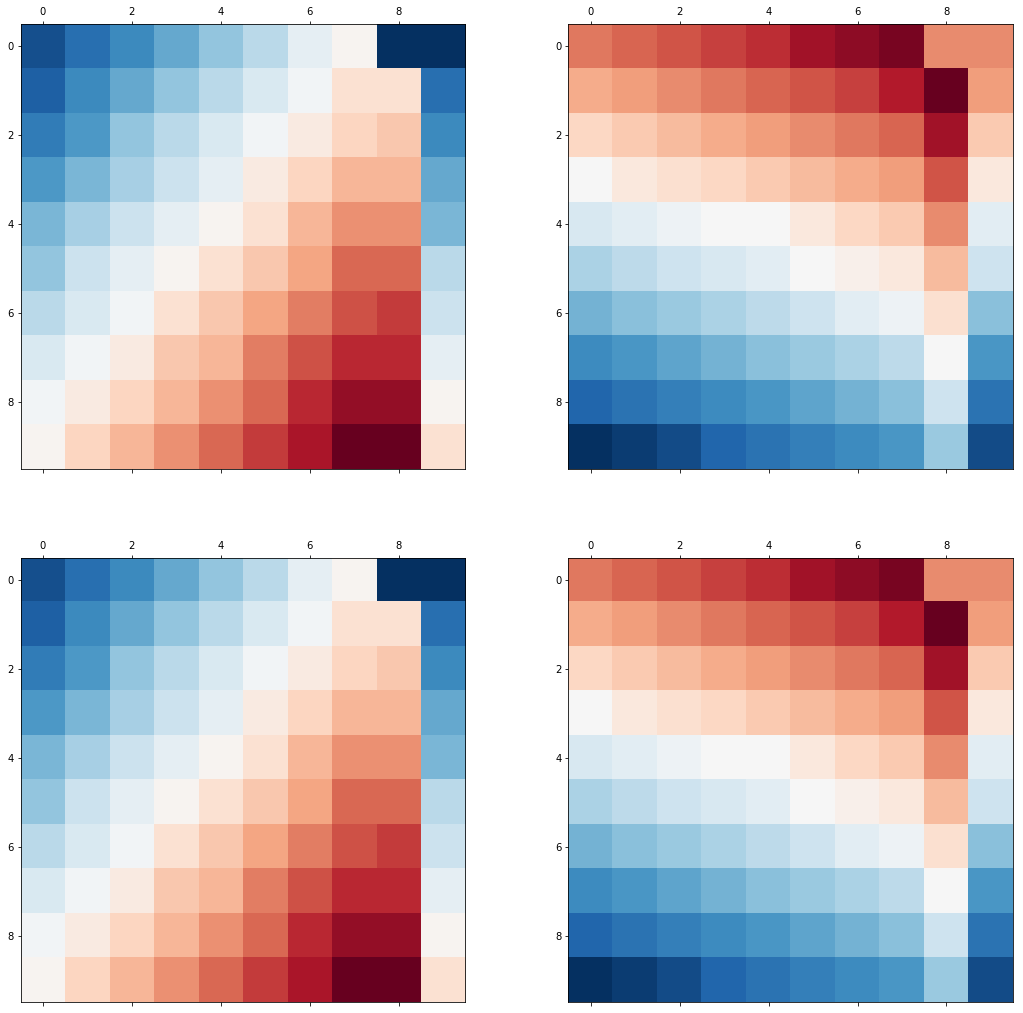

In [42]:
# Plot shifts

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(18,18))
ax11.matshow(diffraction_shifts_position.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_position.data2D['y'],cmap="RdBu")
ax21.matshow(diffraction_shifts_intensity.data2D['x'],cmap="RdBu")
ax22.matshow(diffraction_shifts_intensity.data2D['y'],cmap="RdBu")
plt.show()

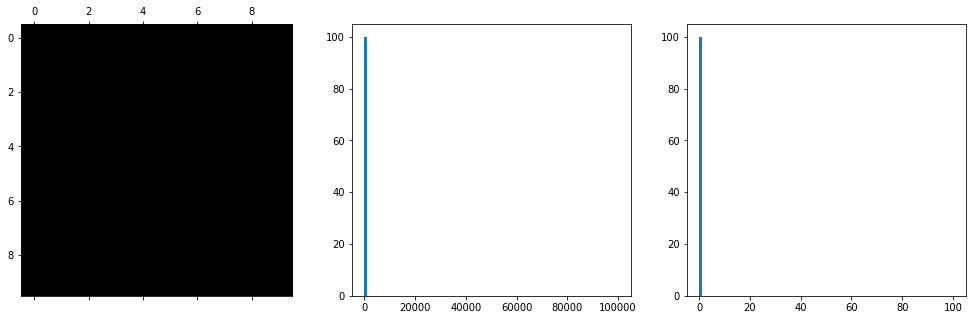

In [43]:
# Take distance between diffraction shifts detemined from positions and intensities

diff2 = (diffraction_shifts_intensity.data2D['x']-diffraction_shifts_position.data2D['x'])**2 + \
        (diffraction_shifts_intensity.data2D['y']-diffraction_shifts_position.data2D['y'])**2

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,5))
ax1.matshow(diff2)
ax2.hist(diff2.ravel(),bins=np.linspace(0,100000,100))
ax3.hist(diff2.ravel(),bins=np.linspace(0,100,100))
plt.show()

In [44]:
# Get the diffraction shifts for each DP
# Use only peaks where the peak (1) with highest intensity and (2) closest to CoM  are the same
# Mask off others

diffraction_shifts = RealSlice(data=np.zeros((3,dc.R_Nx,dc.R_Ny)),
                               parentDataCube=dc,slicelabels=('x','y','known_mask'))
diffraction_shifts.data2D['known_mask'] = diffraction_shifts.data2D['known_mask'].astype(bool)

for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        Rij_point_list = Bragg_peak_point_list.get_subpointlist([('rx',Ri),('ry',Rj)])
        
        r2 = (Rij_point_list.data['qx']-central_beam_qx0)**2 + (Rij_point_list.data['qy']-central_beam_qy0)**2
        index1 = np.argmin(r2)
        index2 = np.argmax(Rij_point_list.data['intensity'])
        
        if index1 == index2:
            diffraction_shifts.data2D['x'][Ri,Rj] = Rij_point_list.data['qx'][index1]
            diffraction_shifts.data2D['y'][Ri,Rj] = Rij_point_list.data['qy'][index1]
            diffraction_shifts.data2D['known_mask'][Ri,Rj] = True

In [45]:
# Subtract off average from diffraction shifts

diffraction_shifts.data2D['x']=diffraction_shifts.data2D['x']-np.average(diffraction_shifts.data2D['x'][diffraction_shifts.data2D['known_mask']])
diffraction_shifts.data2D['y']=diffraction_shifts.data2D['y']-np.average(diffraction_shifts.data2D['y'][diffraction_shifts.data2D['known_mask']])

diffraction_shifts.data2D['x'][diffraction_shifts.data2D['known_mask']==False] = 0
diffraction_shifts.data2D['y'][diffraction_shifts.data2D['known_mask']==False] = 0

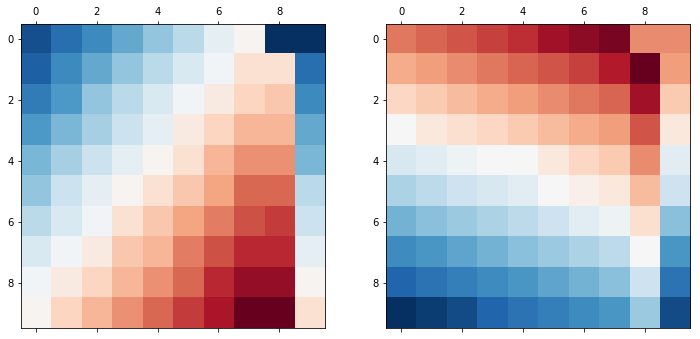

In [46]:
# Plot known shifts

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,18))
ax1.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax2.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
plt.show()

### 2c. Fit diffraction shifts

* Fit plane (or polynomial, or Bezier surface...) to unscattered beam positions

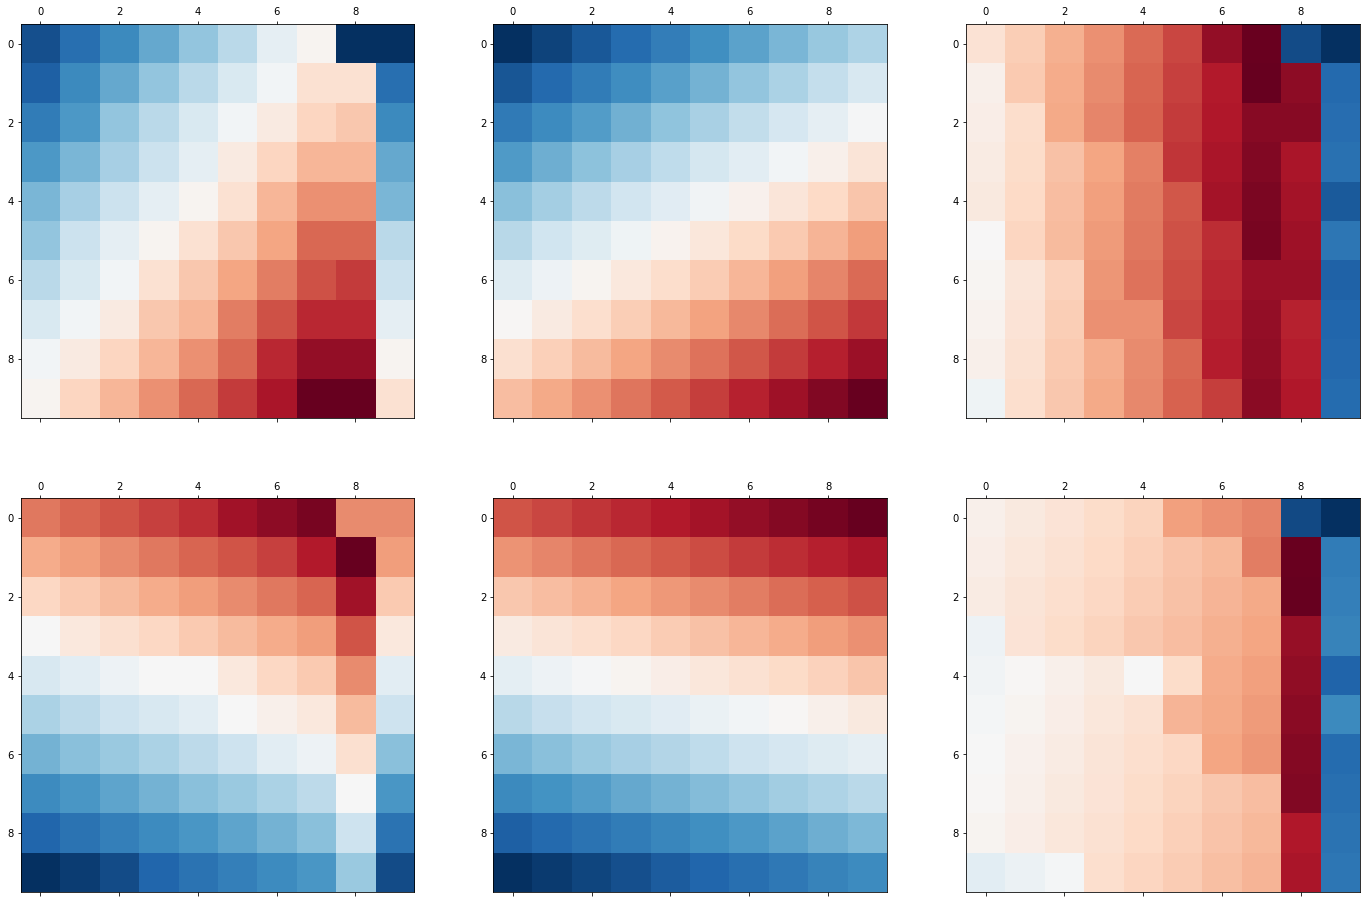

In [47]:
# Fit with all datapoints

fit_function = py4DSTEM.process.fit.plane

diffraction_shifts_fit_all = RealSlice(data=np.zeros((2,dc.R_Nx,dc.R_Ny)),
                                       parentDataCube=dc,slicelabels=('x','y'))

popt_x, pcov_x, diffraction_shifts_fit_all.data2D['x'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['x'])
popt_y, pcov_y, diffraction_shifts_fit_all.data2D['y'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['y'])

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,16))
ax11.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_fit_all.data2D['x'],cmap="RdBu")
ax13.matshow(diffraction_shifts.data2D['x']-diffraction_shifts_fit_all.data2D['x'],cmap="RdBu")
ax21.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
ax22.matshow(diffraction_shifts_fit_all.data2D['y'],cmap="RdBu")
ax23.matshow(diffraction_shifts.data2D['y']-diffraction_shifts_fit_all.data2D['y'],cmap="RdBu")
plt.show()

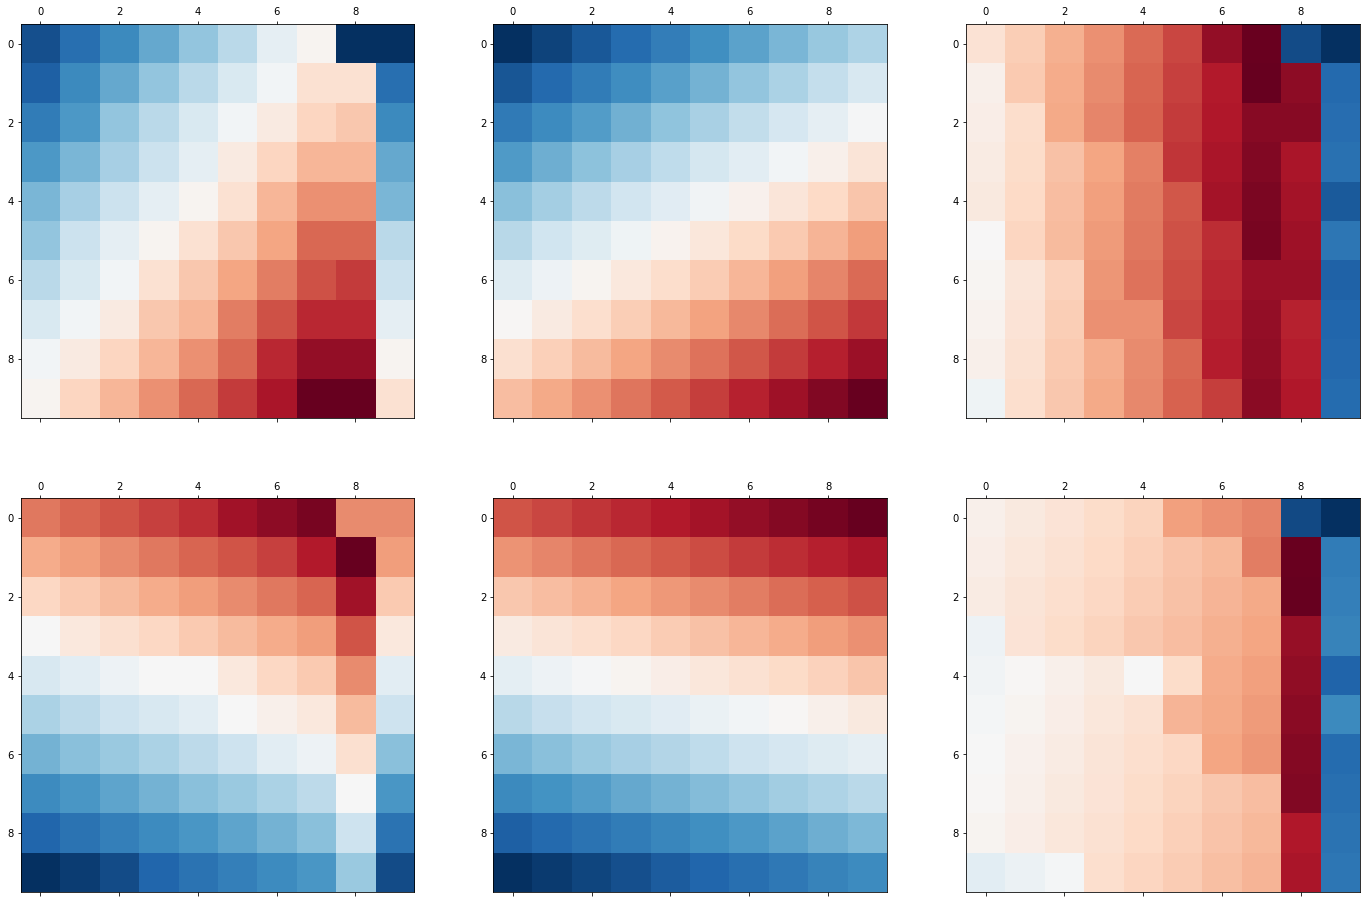

In [48]:
# Fit with only datapoints where diffraction_shifts_known==True

fit_function = py4DSTEM.process.fit.plane

diffraction_shifts_fit = RealSlice(data=np.zeros((2,dc.R_Nx,dc.R_Ny)),
                                    parentDataCube=dc,slicelabels=('x','y'))

popt_x, pcov_x, diffraction_shifts_fit.data2D['x'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['x'], data_mask=diffraction_shifts.data2D['known_mask'])
popt_y, pcov_y, diffraction_shifts_fit.data2D['y'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['y'], data_mask=diffraction_shifts.data2D['known_mask'])

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,16))
ax11.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_fit.data2D['x'],cmap="RdBu")
ax13.matshow(diffraction_shifts.data2D['x']-diffraction_shifts_fit.data2D['x'],cmap="RdBu")
ax21.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
ax22.matshow(diffraction_shifts_fit.data2D['y'],cmap="RdBu")
ax23.matshow(diffraction_shifts.data2D['y']-diffraction_shifts_fit.data2D['y'],cmap="RdBu")
plt.show()

## 3. Correct the diffraction shifts

Finally, the diffraction pattern at each scan position is corrected for the calculated shifts.

* Datacube 
    * Apply shifts at each beam positions
    * Save new, processed datacube
* Averaged deconvolution
    * Apply shifts to recalculated averaged deconvolution

### 3a. Correct diffraction shifts in raw datacube

* Apply shifts at each beam positions
* Save new, processed datacube

In [49]:
# Apply shifts

data4D_corrected = np.empty_like(dc.data4D,dtype='float32')

t0=time()
for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        print("Shifting DP from scan position {},{}".format(i,j))
        data4D_corrected[i,j,:,:] = py4DSTEM.process.utils.get_shifted_ar(dc.data4D[i,j,:,:], 
                                                   -diffraction_shifts_fit.data2D['x'][i,j],
                                                   -diffraction_shifts_fit.data2D['y'][i,j])

t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Shifting DP from scan position 0,0
Shifting DP from scan position 0,1
Shifting DP from scan position 0,2
Shifting DP from scan position 0,3
Shifting DP from scan position 0,4
Shifting DP from scan position 0,5
Shifting DP from scan position 0,6
Shifting DP from scan position 0,7
Shifting DP from scan position 0,8
Shifting DP from scan position 0,9
Shifting DP from scan position 1,0
Shifting DP from scan position 1,1
Shifting DP from scan position 1,2
Shifting DP from scan position 1,3
Shifting DP from scan position 1,4
Shifting DP from scan position 1,5
Shifting DP from scan position 1,6
Shifting DP from scan position 1,7
Shifting DP from scan position 1,8
Shifting DP from scan position 1,9
Shifting DP from scan position 2,0
Shifting DP from scan position 2,1
Shifting DP from scan position 2,2
Shifting DP from scan position 2,3
Shifting DP from scan position 2,4
Shifting DP from scan position 2,5
Shifting DP from scan position 2,6
Shifting DP from scan position 2,7
Shifting DP from sca

In [54]:
# Store new, shifted datacube
datacube_shifted = DataCube(data=data4D_corrected, parentDataCube=dc)

### 3b. Apply diffraction shifts to deconvolution

* Apply shifts to recalculated averaged deconvolution

In [55]:
# Get the shift corrected, average deconvolution

average_deconvolution_shiftcorrected = np.zeros((dc.Q_Ny,dc.Q_Nx))

for i in range(len(Bragg_peak_point_list x)):
    rx = int(Bragg_peak_point_list['rx'][i])
    ry = int(Bragg_peak_point_list['ry'][i])
    shift_qx = int(diffraction_shifts_fit_x[rx,ry])
    shift_qy = int(diffraction_shifts_fit_y[rx,ry])
    qx = int(Bragg_peak_point_list['qx'][i]) - shift_qx
    qy = int(Bragg_peak_point_list['qy'][i]) - shift_qy

    average_deconvolution_shiftcorrected[qx,qy] += Bragg_peak_point_list['intensity'][i]

SyntaxError: invalid syntax (<ipython-input-55-494a4d1b6d62>, line 5)

In [36]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution_shiftcorrected)
x0,y0=int(x0),int(y0)
rad=80

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution_shiftcorrected)
ax12.matshow(average_deconvolution_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution_shiftcorrected**0.15,cmap='jet')
ax22.matshow(average_deconvolution_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad]**0.15,cmap='jet')
plt.show()

/Users/Ben/Work/NCEM/Projects/py4DSTEM/py4DSTEM-master/py4DSTEM/process/utils/utils.py:91: RuntimeWarning: invalid value encountered in double_scalars
  xCoM = np.sum(rx*ar)/tot_intens
/Users/Ben/Work/NCEM/Projects/py4DSTEM/py4DSTEM-master/py4DSTEM/process/utils/utils.py:92: RuntimeWarning: invalid value encountered in double_scalars
  yCoM = np.sum(ry*ar)/tot_intens


ValueError: cannot convert float NaN to integer

In [6]:
# Plot with gaussian blur

sigma = 2

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution_shiftcorrected)
x0,y0=int(x0),int(y0)
rad=80

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,16))
ax1.matshow(gaussian_filter(average_deconvolution_shiftcorrected,sigma)**0.15,cmap='jet')
ax2.matshow(gaussian_filter(average_deconvolution_shiftcorrected,sigma)[x0-rad:x0+rad,y0-rad:y0+rad]**0.15,cmap='jet')
plt.show()

NameError: name 'average_deconvolution_shiftcorrected' is not defined

### 3c. Get deconvolutions from image subregions

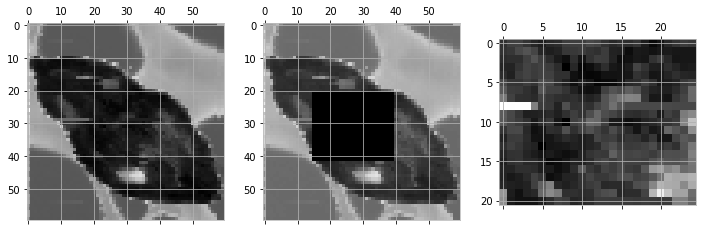

In [51]:
# Select ROI

xmin,xmax=21,42
ymin,ymax=15,40

im_ROI_sel = np.average(dc.data4D,axis=(2,3))
im_ROI_sel[xmin:xmax,ymin:ymax] = 0
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
ax1.matshow(np.average(dc.data4D,axis=(2,3)),cmap='gray')
ax2.matshow(im_ROI_sel,cmap='gray')
ax3.matshow(np.average(dc.data4D,axis=(2,3))[xmin:xmax,ymin:ymax,],cmap='gray')
plt.show()

In [52]:
# Get deconvolution in ROI

average_deconvolution_shiftcorrected_ROI_1 = np.zeros((dc.Q_Ny,dc.Q_Nx))

for i in range(len(Bragg_peak_point_list)):
    rx = int(Bragg_peak_point_list['rx'][i])
    ry = int(Bragg_peak_point_list['ry'][i])
    if ((rx in range(xmin,xmax)) and (ry in range(ymin,ymax))):
        shift_qx = int(diffraction_shifts_fit_x[rx,ry])
        shift_qy = int(diffraction_shifts_fit_y[rx,ry])
        qx = int(Bragg_peak_point_list['qx'][i]) - shift_qx
        qy = int(Bragg_peak_point_list['qy'][i]) - shift_qy

        average_deconvolution_shiftcorrected_ROI_1[qx,qy] += Bragg_peak_point_list['intensity'][i]

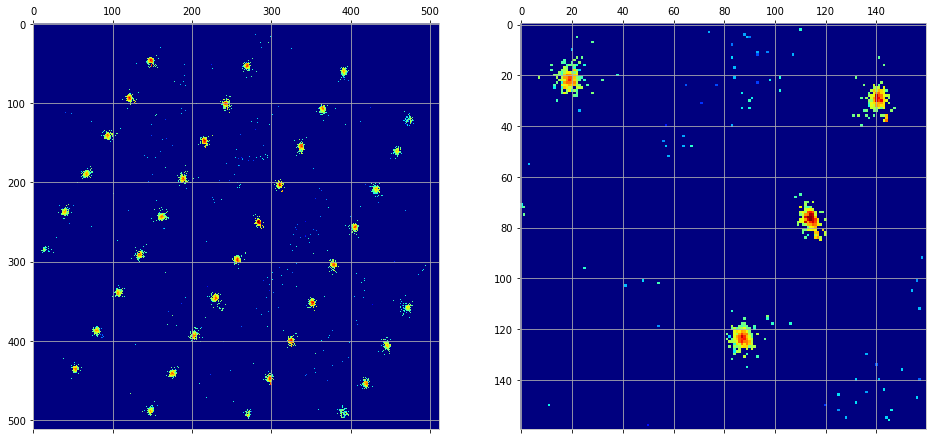

In [53]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution_shiftcorrected_ROI_1)
x0,y0=int(x0),int(y0)
rad=80

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,16))
ax1.matshow(average_deconvolution_shiftcorrected_ROI_1**0.15,cmap='jet')
ax2.matshow(average_deconvolution_shiftcorrected_ROI_1[x0-rad:x0+rad,y0-rad:y0+rad]**0.15,cmap='jet')
plt.show()

### Save

In [56]:
dc.dataobjecttracker.show_dataobjects()

 Index                  Name                        Type           Save   
   0                                        RawDataCube             Y     
   1                                        RealSlice               N     
   2                                        DiffractionSlice        N     
   3                                        DiffractionSlice        N     
   4                                        PointList               N     
   5                                        PointList               N     
   6                                        PointList               N     
   7                                        PointList               N     
   8                                        PointList               N     
   9                                        PointList               N     
   10                                       PointList               N     
   11                                       PointList               N     
   12                    

In [ ]:
# Save
fp="/home/ben/Desktop/example_shiftcorrection.h5"
py4DSTEM.readwrite.save(dc,fp)